# Lensing reconstruction tutorial

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
# We use some stuff we learned before
import cmb_modules
import lens_modules as lm
np.random.seed(100)

In this tutorial, we will learn how to obtain the underlying lensing convergence -- the projected (dark) matter density -- from an observed map of the CMB. 

We will first simulate a lensed CMB map as we learnt in an earlier tutorial

In [2]:
patch_deg_width = 40. # patch width in degrees
pix_size = 1.5 # pixel size in arcminutes
ells,ucltt,lcltt,clkk = lm.get_theory()
N,lensed,kappa,ly,lx,modlmap = lm.get_lensed(patch_deg_width,pix_size,ells,ucltt,clkk)

Let us now convolve this map with a beam and add noise

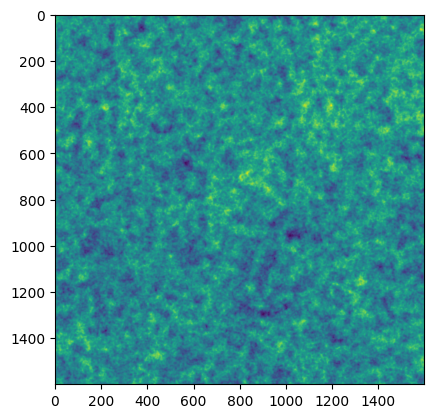

In [4]:
# Beam
beam_arcmin = 1.4
def gauss_beam(ell,fwhm):
    # A gaussian beam transfer function (map-space, i.e. one power)
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))
# Evaluate the beam on an isotropic Fourier grid
kbeam2d = gauss_beam(modlmap,beam_arcmin)
# Filter the map to convolve it with a beam
beamed = lm.filter_map(lensed,kbeam2d)

# Noise
noise_uk_arcmin = 1.5 # CMB-S4 level white noise
# White noise
Clnoise = (noise_uk_arcmin*np.pi/180./60.)**2.
Dlnoise = Clnoise*ells*(ells+1.)/2./np.pi
# Make a GRF noise map
noise_map = cmb_modules.make_CMB_T_map(N,pix_size,ells,Dlnoise)

# The observed map
observed = beamed + noise_map

plt.imshow(observed)
plt.show()

## Lensing reconstruction

Let's expand the lens equation

$\newcommand{\al}{\boldsymbol{\alpha}}$
$\newcommand{\x}{\boldsymbol{x}}$
$\newcommand{\nab}{\boldsymbol{\nabla}}$
$\newcommand{\uT}{{\tilde{T}}}$
$\newcommand{\uC}{{\tilde{C}}}$
$\newcommand{\dphi}{{\nab\phi}}$
$\newcommand{\O}{{\mathcal{O}}}$
$\newcommand{\l}{{\boldsymbol{\ell}}}$
$\newcommand{\L}{{\boldsymbol{L}}}$
$$T(\x) = \uT(\x+\al)$$

in a Taylor series (and substitute $\al=\dphi$) in the weak-lensing limit of small $\phi$,

$$
T(\x) \approx \uT(\x) + \nabla \uT \cdot \dphi + \O(\dphi^2)
$$ 

HOMEWORK EXERCISE: Using 2d Fourier transforms,

$$
X(\l) = \int d^2\x ~e^{-i\l\cdot\x}X(\x)
$$
$$
X(\x) = \int \frac{d^2\l}{(2\pi)^2} ~e^{i\l\cdot\x}X(\l)
$$
$$
\int d^2\x e^{i\l\cdot\x} = (2\pi)^2 \delta(\l)
$$

show that to leading order in the lensing potential, lensing induces coupling between modes of the CMB map:


$$
\langle T(\l_1)T(\l_2) \rangle_{\rm CMB} = \phi(\L)\left[\uC^{TT}_{\ell_1}(\L \cdot \l_1) + \uC^{TT}_{\ell_2}(\L \cdot \l_2)\right]
$$

where the averaging is over realizations of the unlensed CMB field $\uT$. The above result motivates extracting modes of the lensing potential $\phi(\L)$ by taking a weighted average of products of CMB modes. The weights can be derived such that the noise in the reconstruction is minimized. The resulting estimator is:

$$
\hat{\kappa}(\L) = -A(\L) \int d^2\l_1 \left[\uC^{TT}_{\ell_1}(\L \cdot \l_1) + \uC^{TT}_{\ell_2}(\L \cdot \l_2)\right]\frac{T(\l_1)T(\l_2)}{C^{TT}_{\ell_1}C^{TT}_{\ell_2}}
$$

HOMEWORK EXERCISE: Show that the above estimator can be written as a real-space multiplication

$$
\hat{\kappa} \propto -\nabla \cdot \left[\left(\nabla T_W\right) T_H \right]
$$

where $T_W$ is the temperature map Wiener filtered by $\frac{\uC^{TT}_{\ell}}{C^{TT}_{\ell}}$ and $T_H$ is the temperature map inverse variance filtered by $\frac{1}{C^{TT}_{\ell}}$.

In [5]:
# Now we attempt to reconstruct a lensing map from the observed map
def qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx):
    """
    The simplest form of the quadratic estimator is

    kappa_recon = - div ( grad(T) T )
    where grad(T) is Wiener filtered with (unlensed_cmb_power/total_cmb_power)
    and T is filtered with (1/total_cmb_power)
    where the T map is beam deconvolved and
    where total_cmb_power = lensed_cmb_power + noise_power / beam^2

    The reconstruction is limited to ellmin < ells < ellmax of the CMB temperature map.

    The grad and div operations require knowledge of:
    modlmap: absolute wavenumbers of Fourier pixels
    ly: map of ly Fourier coordinate of each pixel
    lx: map of lx Fourier coordinate of each pixel
    (note modlmap = sqrt(ly**2 + lx**2)
    """
    inv_noise_filter = lm.kmask((1./total_cmb_power_2d),modlmap,ellmin,ellmax)
    grad_filter = lm.kmask((unlensed_cmb_power_2d/total_cmb_power_2d),modlmap,ellmin,ellmax)

    gradTy,gradTx = lm.gradient(tmap,ly,lx)

    # The Wiener filtered gradient Grad(T_G)
    filtered_gradTy = lm.filter_map(gradTy,grad_filter)
    filtered_gradTx = lm.filter_map(gradTx,grad_filter)
    # The inverse variance filtered T_H
    filtered_T = lm.filter_map(tmap,inv_noise_filter)
    
    ############## COMPLETE THIS!!!
    # ADD A LINE BELOW TO GET ukappa = divergence(Grad(T_G) * T_H)
    ############## COMPLETE THIS!!!
    
    # We filter with 1/L^2 at the end to make the normalization white
    return -lm.filter_map(ukappa,lm.kmask(1/modlmap**2,modlmap,ellmin=2))

# For this we also need to know how to calculate a divergence
def div(imapy,imapx,ly,lx):
    # Return divergence grad(Y)_y + grad(X)_x
    ############## COMPLETE THIS!!!
    # COMPLETE THIS FUNCTION THAT RETURNS THE DIVERGENCE
    ############## COMPLETE THIS!!!
    return divergence


def interp(x,y,bounds_error=False,fill_value=0.,**kwargs):
    # Just a simple interpolator that fills with zeros by default
    from scipy.interpolate import interp1d
    return interp1d(x,y,bounds_error=bounds_error,fill_value=fill_value,**kwargs)


# To use this we need unlensed and total spectra interpolated on to the 2D Fourier grid
### Prepare 2D Fourier space interpolations of theory spectra
unlensed_cmb_power_2d = interp(ells,ucltt)(modlmap)
total_cmb_power_2d = interp(ells,lcltt)(modlmap) + Clnoise/kbeam2d**2.


### The noise was specified for a beam deconvolved map so we deconvolve the beam from our map
tmap = lm.filter_map(observed,1/kbeam2d)

### Next, we get the unnormalized reconstruction after choosing what multipoles to involve
ellmin = 10
ellmax = 3000
ukappa = qe_reconstruct(tmap,unlensed_cmb_power_2d,total_cmb_power_2d,ellmin,ellmax,modlmap,ly,lx)

# Calculating the normalization is a bit involved, so for now we focus on comparing
# the largest scales of the reconstruction with that of the input, where the normalization is
# expected to be somewhat constant

### Filter the reconstruction and the input kappa to the same ellrange (where the normalization
### is expected to be relatively white)
kellmin = 10
kellmax = 100
ukappa_f = lm.filter_map(ukappa,lm.kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))
ikappa_f = lm.filter_map(kappa,lm.kmask(modlmap*0.+1.,modlmap,kellmin,kellmax))

# Plot the filtered maps for comparison
plt.imshow(ukappa_f,cmap='gray')
plt.show()
plt.clf()
plt.imshow(ikappa_f,cmap='gray')
plt.show()
plt.clf()



NameError: name 'ukappa' is not defined

You should be able to see a correspondence of peaks and valleys by eye in the above reconstruction if you have implemented it correctly. To be absolute sure, we will next cross-correlate the reconstruction with the input.

## Cross power with input

EXERCISE: This looks good by eye! But are we sure it's not just a coincidence? The systematic way of checking that your lensing pipeline is working is to cross-correlate your reconstruction with the input kappa you provided. Calculate the binned 1d cross power and confirm it is non-zero. 

In [7]:
### Calculate binned 1d cross-power between reconstruction and input
ell_max = 1000
delta_ell = 10

